#Deprecated

In [ ]:
#@title Spectral Sparsification by GPT and according to Paper (1st take - ignore for now)
%%script echo skipping
def spectral_sparsification(graph,centroid_points,pred,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points):
  #============Start Plots===============
  ax = plt.axes()
  ax.set_ylim([0,img_h])
  ax.set_xlim([0, img_w])
  ax.invert_yaxis()
  ax.imshow(img, cmap="gray")

  #============Initiate Graph==================
  k = len(centroid_points)-1

  my_graph = deepcopy(graph)

  pred_pairs = [(pred[i], pred[i+1]) for i in range(len(pred)-1)]  # Create List with each value being and array of two consecutive points
  new_pred_pairs = []
  for item in pred_pairs:
    if item[0] != item[1]:
      new_pred_pairs.append(item)
  my_graph.add_edges_from(new_pred_pairs)                      # Add edges between consecutive points in pred_pairs

  #==============Sparsification==================
  # Convert the NetworkX graph to a sparse adjacency matrix
  adjacency_matrix = nx.adjacency_matrix(my_graph)
  # Compute the Laplacian matrix
  laplacian = nx.laplacian_matrix(my_graph).astype(float)
  # Compute the eigenvectors and eigenvalues of the Laplacian
  eigenvalues, eigenvectors = splinalg.eigsh(laplacian, k=k, which='SM')
  # Determine the probabilities for sparsification based on the number of non-zero entries
  nnz = adjacency_matrix.nnz
  probabilities = np.ones(nnz) / nnz
  # Sample edges from the graph based on probabilities, considering duplicate edges
  edges = adjacency_matrix.nonzero()
  sampled_edge_indices = np.random.choice(nnz, size=k, p=probabilities, replace=False)
  sampled_edges = (edges[0][sampled_edge_indices], edges[1][sampled_edge_indices])
  sampled_edge_weights = adjacency_matrix[sampled_edges]
  # Create a sparsified adjacency matrix using sampled edges and their weights
  sparsified_adjacency = sp.coo_matrix((sampled_edge_weights, sampled_edges), shape=adjacency_matrix.shape)
  # Convert the sparsified adjacency matrix to a dense matrix
  sparsified_dense = sparsified_adjacency.toarray()
  # Create a NetworkX graph from the dense matrix
  sparsified_graph = nx.from_numpy_array(sparsified_dense)

  #==========Draw the graph and save img============
  pos = nx.get_node_attributes(my_graph, 'pos')
  sizen = nx.get_node_attributes(my_graph, 'size')
  nx.draw(sparsified_graph, pos, node_size=list(sizen))       # Draw the graph with node positions
  for one_ellipse in ellipses_points:
    tmp = copy(one_ellipse)
    ax.add_patch(tmp)

  plt.savefig(f"/content/drive/MyDrive/REFLACX-Study/BIRCH-Images/EyeGaze-vs-Reflacx/{timestamped}/{type_xray}/{patient}_Spectral_clusters-{len(centroid_points)}")
  #plt.show()
  plt.cla()

#Spectral Sparsification According to the Paper

from collections import Counter
N = 0
C = 1
def ssPaper(graph,centroid_points, pred, img_h, img_w, img,type_xray,patient,timestamped,ellipses_points):
  #============Start Plots===============
  ax = plt.axes()
  ax.set_ylim([0,img_h])
  ax.set_xlim([0, img_w])
  ax.invert_yaxis()
  ax.imshow(img, cmap="gray")

  #============Initiate Graph==================
  k = len(centroid_points)-1

  my_graph = deepcopy(graph)
  pred_pairs = [(pred[i], pred[i+1]) for i in range(len(pred)-1)]

  m = len(pred_pairs)                       # number of edges
  n = len(centroid_points)                  # number of nodes
  edge_counter = dict(Counter(pred_pairs))  # number of times a edge repeats
  node_counter = dict(Counter(pred))        # node_counter[0] = (N) number of nodes in a cluster
                                            # node_counter[1] = (C) number of self loops

  for item, value in edge_counter.items():
    if item[0] == item[1]:
      node_counter[item[0]] = [node_counter[item[0]], value]

  for item,value in node_counter.items():
    if type(value) != list:
      node_counter[item] = [value,0]

  my_graph.add_edges_from(pred_pairs)

  #============Sparcification==================
  adjacency_matrix = nx.adjacency_matrix(my_graph)     # Adjacency Matrix
  laplacian = nx.laplacian_matrix(my_graph).todense()  # Laplacian Matrix
  Lp = np.linalg.pinv(laplacian)                            # (Lp is the pseudoinverse of L)
  degrees = [val for (node, val) in my_graph.degree()]
  print(laplacian)

  # effective res  = ((Ei-Ej)**T) x Lp x (Ei-Ej)
  effective_res = np.zeros(m)
  # weight formula = exp((-Ni^2 x Ci)^-1) x exp((-Nj^2 x Cj)^-1)
  weights = np.zeros(m)

  aux = 0
  for item, value in edge_counter.items():
    i = item[0]
    j = item[1]

    e_i = np.zeros(n)
    e_i[i] = 1
    e_j = np.zeros(n)
    e_j[j] = -1
    effective_res[aux] = (e_i-e_j).transpose() @ Lp @ (e_i-e_j)

    Ni = node_counter[i][N]
    Ci = node_counter[i][C]
    Nj = node_counter[j][N]
    Cj = node_counter[j][C]

    if Ni == 0 or Ci == 0 or Nj == 0 or Cj == 0:
      weights[aux] = 0
    else:
      expi = math.exp(((-Ni**2) * Ci)**-1)
      expj = math.exp(((-Nj**2) * Cj)**-1)
      weights[aux] = expi*expj

    aux +=1

  new_weights = weights * effective_res
  probs = new_weights / np.sum(new_weights)

  # Sample edges from the graph based on probabilities, considering duplicate edges
  edges = adjacency_matrix.nonzero()
  sampled_edge_indices = np.random.choice(m, size=k, p=probs, replace=False)
  sampled_edges = (edges[0][sampled_edge_indices], edges[1][sampled_edge_indices])
  sampled_edge_weights = adjacency_matrix[sampled_edges]
  # Create a sparsified adjacency matrix using sampled edges and their weights
  sparsified_adjacency = sp.coo_matrix((sampled_edge_weights, sampled_edges), shape=adjacency_matrix.shape)
  # Convert the sparsified adjacency matrix to a dense matrix
  sparsified_dense = sparsified_adjacency.toarray()
  # Create a NetworkX graph from the dense matrix
  sparsified_graph = nx.from_numpy_array(sparsified_dense)

  #==========Draw the graph and save img============
  pos = nx.get_node_attributes(my_graph, 'pos')
  sizen = nx.get_node_attributes(my_graph, 'size')
  nx.draw(sparsified_graph, pos, node_size=list(sizen))       # Draw the graph with node positions
  for one_ellipse in ellipses_points:
    tmp = copy(one_ellipse)
    ax.add_patch(tmp)

  plt.savefig(f"/content/drive/MyDrive/REFLACX-Study/BIRCH-Images/EyeGaze-vs-Reflacx/{timestamped}/{type_xray}/{patient}_SpectralPaper_clusters-{len(centroid_points)}")
  #plt.show()
  plt.cla()

In [ ]:
#@title Apply the BIRCH algorithm (ignore for now)
%%script echo skipping
def trainBirchGetResults(ellipses_points,points,nn,img_h,img_w,img,id,type_xray,patient,timestamped):
  # Create the BIRCH model and fit the REFLACX data
  if(len(points) > 0):
    model = Birch(branching_factor=200, n_clusters=None, threshold = 90.5472)
    model.fit(points)
    pred = model.predict(points)
    centroid_points = model.subcluster_centers_
    nb_cluster = len(centroid_points)
    node_counter = dict(Counter(pred))        # number of nodes in a cluster

    # Create a graph
    graph = nx.Graph()
    todivide = len(points)
    for i in range(len(centroid_points)):
      # Add the nodes with the coordinates of the corresponding centroid
      graph.add_node(i, pos=(centroid_points[i][0],centroid_points[i][1]), size=node_counter[i]/todivide)

    NNSparcification(graph,nn,centroid_points,nb_cluster,img_h,img_w,img,id,type_xray,patient,timestamped,ellipses_points)
    #spectral_sparsification(graph,centroid_points,pred,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points)
    #sequential_graph(graph,nb_cluster, pred, centroid_points,img_h,img_w,img,id,type_xray,patient,timestamped,ellipses_points)
    #ssPaper(graph,centroid_points,pred,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points)

def clusterWithBirch(key, sname, pname, size_x, size_y, image_path, fixations_path, eyegaze_path, id, eyegaze_time_path, reflacx_time_path, ellipses_path):
  try:
    fixations = pd.read_csv(fixations_path)
    reflacx_timestamp = pd.read_csv(reflacx_time_path)
    eyegaze_fixations = pd.read_csv(eyegaze_path)
    all_ellipses = pd.read_csv(ellipses_path)
    eyegaze_timestamp = json.load(open(eyegaze_time_path))
    img = plt.imread(image_path)
  except FileNotFoundError:
    return 0

  reflacx_start = reflacx_timestamp['timestamp_start_word'][0]
  eyegaze_start = eyegaze_timestamp['time_stamped_text'][0]['begin_time']

  plt.rcParams["figure.dpi"] = 300
  plt.rcParams["figure.autolayout"] = True
  fig = plt.figure()

  sample = fixations
  IMG_W = size_x
  IMG_H = size_y

  init = fixations[(fixations.xmin_shown_from_image == 0) & (fixations.ymin_shown_from_image == 0)].head(1)
  # get initial screeen coordinates
  screen_xmin = init.xmin_in_screen_coordinates.values[0]
  screen_xmax = init.xmax_in_screen_coordinates.values[0]
  screen_ymin = init.ymin_in_screen_coordinates.values[0]
  screen_ymax = init.ymax_in_screen_coordinates.values[0]

  left_menu_Xsize_img = int(np.round((screen_xmin*(IMG_W))/(SCREEN_RES[0]-(screen_xmin)),0))
  right_menu_Xsize_img = left_menu_Xsize_img

  x_left = [-1*(left_menu_Xsize_img-1), -1]
  x_right = [IMG_W+1, IMG_W+1+right_menu_Xsize_img]

  ellipses_points = []
  space_points = []
  ms_space_points = []
  silence_space_points = []
  eye_space_points = []
  eye_ms_space_points = []
  eye_silence_space_points = []

  #for (xmin,ymin,xmax,ymax) in zip(all_ellipses["xmin"].values, all_ellipses["ymin"].values, all_ellipses["xmax"].values, all_ellipses["ymax"].values):
  #  ellipses_points.append(elipsedraw([xmin,ymin,xmax,ymax]))

  for (timestamp_sample, x_img, y_img) in zip(sample["timestamp_sample"].values, sample["x_position"].values, sample["y_position"].values):
    if x_img < x_left[1] or x_right[0] < x_img or y_img > IMG_H or y_img < 0:
      pass
    else:
      if not math.isnan(x_img) or not math.isnan(y_img):
        """
        if timestamp_sample >= reflacx_start:
          ms_space_points.append([x_img,y_img,timestamp_sample])
        else:
          silence_space_points.append([x_img,y_img,timestamp_sample])
        #"""
        space_points.append([x_img,y_img])
  """
  for (timestamp_sample,x_img, y_img) in zip(eyegaze_fixations["Time (in secs)"].values, eyegaze_fixations["X_ORIGINAL"].values, eyegaze_fixations["Y_ORIGINAL"].values):
    #usar blink id
    if x_img < 0 or y_img < 0:
      pass
    else:
      if not math.isnan(x_img) or not math.isnan(y_img):
        if timestamp_sample >= eyegaze_start:
          eye_ms_space_points.append([x_img,y_img,timestamp_sample])
        else:
          eye_silence_space_points.append([x_img,y_img,timestamp_sample])
        eye_space_points.append([x_img,y_img])
  #"""

  space_points = np.array(space_points)
  ms_space_points = np.array(ms_space_points)
  silence_space_points = np.array(silence_space_points)
  eye_space_points = np.array(eye_space_points)
  eye_ms_space_points = np.array(eye_ms_space_points)
  eye_silence_space_points = np.array(eye_silence_space_points)

  nn = 3

  #"""
  trainBirchGetResults(ellipses_points,silence_space_points,nn,IMG_H,IMG_W,img,id,'Reflacx',key,'Silence')
  #trainBirchGetResults(ellipses_points,ms_space_points,nn,IMG_H,IMG_W,img,id,'Reflacx',key,'Speech')
  #trainBirchGetResults(ellipses_points,space_points,nn,IMG_H,IMG_W,img,id,'Reflacx',key,'All')
  #trainBirchGetResults(ellipses_points,eye_silence_space_points,nn,IMG_H,IMG_W,img,id,'EyeGaze',key,'Silence')
  #trainBirchGetResults(ellipses_points,eye_ms_space_points,nn,IMG_H,IMG_W,img,id,'EyeGaze',key,'Speech')
  #trainBirchGetResults(ellipses_points,eye_space_points,nn,IMG_H,IMG_W,img,id,'EyeGaze',key,'All')
  plt.close()
  #"""
  return id+1

#Setup

In [1]:
#@title Start up
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%pip install ffmpeg
%pip install grakel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import pickle
import cv2
import math
import json
import os
from copy import copy
from copy import deepcopy
from google.colab.patches import cv2_imshow
from IPython.display import HTML

from grakel import GraphKernel
from collections import defaultdict
from collections import Counter
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

rootdir = "/content/drive/MyDrive/XAMI-MIMIC"
%matplotlib inline


# show all rows from dataframe
pd.set_option('display.max_rows', 100)
# show all columns from dataframe
pd.set_option('display.max_columns', 100)
from IPython.display import Image, clear_output
clear_output()

In [2]:
#@title Init Variables
SCREEN_RES = [3180, 2160]

FONT_SIZE = 4
"""
with open("/content/drive/MyDrive/REFLACX-Study/Pickle/reflacx_dirs.pkl",'rb') as file:
  _reflacx = pickle.load(file)

with open("/content/drive/MyDrive/REFLACX-Study/Pickle/fixations.pkl",'rb') as file:
  #reflacx_fixations {id: [normal_fixs, silence_fixs, ms_fixs], ...}
  #fixations is array [x,y,raw_time,timestamp]
  _fixations = pickle.load(file)

with open("/content/drive/MyDrive/REFLACX-Study/Pickle/ellipses.pkl",'rb') as file:
  #reflacx_ellipses {id: ellipse_id:[[certainty,xmin,ymin,xmax,ymax,label]], ...}
  _ellipses = pickle.load(file)
"""

with open("/content/drive/MyDrive/Colab-Variables/reflacx_gaze.pkl",'rb') as file:
  _reflacx = pickle.load(file)
with open("/content/drive/MyDrive/Colab-Variables/reflacx_speech_gaze.pkl",'rb') as file:
  _reflacx_speech = pickle.load(file)


#BIRCH CSVs

In [ ]:
#@title Spectral Spar Algorithm

def SpectralSparsification(report,model,pred,gaze,points,path):
    num_clusters = len(model.subcluster_labels_)
    directed_adjacency =  np.zeros((num_clusters, num_clusters)).astype(int)

    gaze['cluster'] = pred.astype(int)
    for i in range(len(gaze)-1):
        u_cluster = gaze.iloc[i]['cluster']
        v_cluster = gaze.iloc[i+1]['cluster']
        directed_adjacency[int(u_cluster), int(v_cluster)] += 1

    undirected_adjacency = directed_adjacency + directed_adjacency.T
    np.fill_diagonal(undirected_adjacency, undirected_adjacency.diagonal() // 2)

    # create a graph
    centroid_x = model.subcluster_centers_[:, 0]
    centroid_y = model.subcluster_centers_[:, 1]

    # Add nodes to the graph and set their positions
    new_data = []
    new_data_s = []
    for (i, x, y) in zip(model.subcluster_labels_, centroid_x, centroid_y):
        N = len(gaze[gaze['cluster'] == i])
        C = undirected_adjacency[i,i] + 1

        tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
        new_data.append(tmp)

    df = pd.DataFrame(new_data, columns=['x', 'y', 'weight', 'weight_s'])

    df.to_csv(path + '/fixations.csv', index=False)

In [ ]:
#@title train
def trainBirch(report,gaze,points,path,br,thr):
    # Create the BIRCH model and fit the REFLACX data
    if os.path.exists(path + '/fixations.csv'):
        pass
    else:
        if thr == 90:
            thr = 90.5472
        if(len(points) > 0):
            model = Birch(branching_factor=br, n_clusters=None, threshold = thr)
            model.fit(points)
            pred = model.predict(points)
            SpectralSparsification(report,model,pred,gaze,points,path)
        else:
            df = pd.DataFrame(columns=['x', 'y', 'weight', 'weight_s'])
            df.to_csv(path + '/fixations.csv', index=False)

In [ ]:
brs = [100,150,200]
thrs = [50]

from tqdm.notebook import tqdm

for br in brs:
    for thr in thrs:
        print(thr,br)
        for key, item in tqdm(_reflacx_speech.items()):
            dir_path = '/content/drive/MyDrive/speech_birch_weights/th' + str(thr) + '_br' + str(br) + '/' + str(key)
            os.makedirs(dir_path, exist_ok = True)
            reflacx_points = np.array([(x,y) for x, y in zip(item['x_position'], item['y_position'])])
            trainBirch(key,item,reflacx_points,dir_path,br,thr)

50 75


  0%|          | 0/3032 [00:00<?, ?it/s]

50 100


  0%|          | 0/3032 [00:00<?, ?it/s]

<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarn

50 150


  0%|          | 0/3032 [00:00<?, ?it/s]

<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarn

50 200


  0%|          | 0/3032 [00:00<?, ?it/s]

<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarning: divide by zero encountered in double_scalars
  tmp = [x, y, np.e**((-(N**2)*C).astype(float)**(-1)), N + C]
<ipython-input-3-7e86a0c0f1e8>:27: RuntimeWarn

In [ ]:
_reflacx_speech = {}
_reflacx_silence = {}
_reflacx_df = pd.read_csv('/content/drive/MyDrive/Colab-Variables/reflacx_meta_df.csv')
from tqdm.notebook import tqdm
for key, value in tqdm(_reflacx.items()):
    aux = _reflacx_df[_reflacx_df['id'] == key]
    aux = aux.iloc[0]
    reflacx_time_path = f"/content/drive/MyDrive/XAMI-MIMIC/patient_{aux['subject_id']}/REFLACX/{aux['id']}/timestamps_transcription.csv"
    reflacx_timestamp = pd.read_csv(reflacx_time_path)
    reflacx_start = reflacx_timestamp['timestamp_start_word'][0]
    reflacx_gaze = _reflacx[aux['id']]
    reflacx_gaze_speech = reflacx_gaze[reflacx_gaze['timestamp_sample'].ge(reflacx_start)]
    reflacx_gaze_silence = reflacx_gaze[reflacx_gaze['timestamp_sample'].lt(reflacx_start)]
    _reflacx_speech[aux['id']] = reflacx_gaze_speech
    _reflacx_silence[aux['id']] = reflacx_gaze_silence

  0%|          | 0/3032 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/MyDrive/Colab-Variables/reflacx_speech_gaze.pkl', 'wb') as file:
    pickle.dump(_reflacx_speech, file)
with open('/content/drive/MyDrive/Colab-Variables/reflacx_silence_gaze.pkl', 'wb') as file:
    pickle.dump(_reflacx_silence, file)

In [ ]:
import shutil
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += files.count('fixations.csv')
    return count

brs = [50,75,100,150,200,250,300]
thrs = [50,75,90,100,150,200,250,300]
for br in brs:
  for th in thrs:
    main_dir = f"/content/drive/MyDrive/birch_weights/th{th}_br{br}"
    file_count = count_files(main_dir)
    print(f"Number of files in th{th}_br{br}: {file_count}")

#Sparse Functions

In [4]:
#@title Evaluate Cluster
# https://towardsdatascience.com/three-performance-evaluation-metrics-of-clustering-when-ground-truth-labels-are-not-available-ee08cb3ff4fb
# https://towardsdatascience.com/how-to-evaluate-clustering-performance-without-ground-truth-labels-9c9792ec1c54
# ward distance, pairwise distances

_scores = [0,0,0]
def evaluateCluster(br, radius, X, labels):
  sil = round(metrics.silhouette_score(X,labels),3)
  #chs = round(metrics.calinski_harabasz_score(X,labels),3)
  dbs = round(metrics.davies_bouldin_score(X,labels),3)
  #print(sil,chs,dbs,br,radius)
  _scores[0] += sil
  #_scores[1] += chs
  _scores[2] += dbs


def resetScores():
  global _scores
  _scores = [0,0,0]


In [5]:
#@title Sequential Graph
def sequential_graph(graph,nb_clusters,points,centroid_points,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points):

  cluster_order = np.full(nb_clusters, -1)
  for index, value in np.ndenumerate(points):
    if value < nb_clusters and cluster_order[value] == -1:
      cluster_order[value] = index[0]
  sorted_indices = (np.argsort(cluster_order)).tolist()
  ordered_clusters = [(sorted_indices[i], sorted_indices[i+1]) for i in range(len(sorted_indices)-1)]

  my_graph = deepcopy(graph)
  my_graph.add_edges_from(ordered_clusters)

  drawPlotSave(ellipses_points,img_h,img_w,img,my_graph,timestamped,type_xray,'Sequence',patient,nb_clusters)

In [6]:
#@title Sparcification with NN
def NNSparcification(graph,k,centroid_points,nb_clusters,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points):
  ax = plt.axes()
  ax.set_ylim([0,img_h])
  ax.set_xlim([0, img_w])
  ax.invert_yaxis()
  ax.imshow(img, cmap="gray")

  my_graph = deepcopy(graph)

  # Use NearestNeighbor to find which nodes will connect to which
  k = len(centroid_points) if len(centroid_points) < k else k
  nn = NearestNeighbors(n_neighbors=k).fit(centroid_points)
  distances, indices = nn.kneighbors(centroid_points)

  for i in range(len(centroid_points)):
    for j in indices[i][1:]:
      my_graph.add_edge(i,j)

  drawPlotSave(ellipses_points,img_h,img_w,img,my_graph,timestamped,type_xray,'NN',patient,nb_clusters)


In [7]:
#@title Spectral Spar Algorithm
graphs_before_spar = {}
def SpectralSparsification(model,pred,gaze,points,ellipses_points,img_height,img_width,img,type_xray,patient,timestamped):

  # create an directed adjacency matrix first
  num_clusters = len(model.subcluster_labels_)
  directed_adjacency =  np.zeros((num_clusters, num_clusters)).astype(int)

  # 1. all the vertices pertaining to each cluster are removed except the centroid of the cluster
  # 2. all the edges that were connecting vertices from different clusters now connect the corresponding centroids
  # 3. all the edges that were connecting vertices inside each cluster are modeled as self loops on the centroid

  gaze['cluster'] = pred.astype(int)
  for i in range(len(gaze)-1):
    u_cluster = gaze.iloc[i]['cluster']
    v_cluster = gaze.iloc[i+1]['cluster']
    directed_adjacency[int(u_cluster), int(v_cluster)] += 1

  # then, transform the adjacency matrix to undirected
  undirected_adjacency = directed_adjacency + directed_adjacency.T
  for i in range(len(undirected_adjacency)):
    undirected_adjacency[i, i] /=2

  # create a graph
  centroid_x = model.subcluster_centers_[:, 0]
  centroid_y = model.subcluster_centers_[:, 1]

  node_counter = dict(Counter(pred))        # number of nodes in a cluster
  todivide = len(points)

  G = nx.Graph()
  # Add nodes to the graph and set their positions
  for (i, x, y) in zip(model.subcluster_labels_, centroid_x, centroid_y):
    N = len(gaze[gaze['cluster'] == i])
    C = undirected_adjacency[i,i] + 1
    G.add_node(i, pos=(x,y), N=N, C=C,size=node_counter[i]/todivide)

  # Add edges to the graph and set their weights
  for i in range(len(undirected_adjacency)):
    for j in range(len(undirected_adjacency[i])):
      if undirected_adjacency[i][j] > 0:
        G.add_edge(i, j, weight=undirected_adjacency[i][j])

  graphs_before_spar[id] = G
  n = G.number_of_nodes()
  m = G.number_of_edges()

  # so first, we get the matrix
  L = nx.laplacian_matrix(G).todense()
  #A = nx.adjacency_matrix(G).todense()

  L_plus = np.linalg.pinv(L)
  effective_resistance = np.zeros(m)
  custom_weights = np.zeros(m)
  for i, (u, v) in enumerate(G.edges()):
    data = G.get_edge_data(u, v)
    e_u = np.zeros(n)
    e_u[u] = 1
    e_v = np.zeros(n)
    e_v[v] = 1

    R_uv = (e_u-e_v).T @ L_plus @ (e_u-e_v)
    effective_resistance[i] = R_uv

    N_u = G.nodes[u]['N']
    N_v = G.nodes[v]['N']
    C_u = G.nodes[u]['C']
    C_v = G.nodes[v]['C']

    # custom_weights[i] = (np.exp(-(N_u**2)*C_u)**(-1)) * (np.exp(-np.power(N_v,2)*C_v)**(-1)) # according to the paper,
    custom_weights[i] = np.e**((-(N_u**2)*C_u).astype(float)**(-1)) * np.e**((-(N_v**2)*C_v).astype(float)**(-1))

  combined_weights = custom_weights * effective_resistance
  p = combined_weights / np.sum(combined_weights)

  pot_k = m - len(list(nx.nodes_with_selfloops(G)))
  k = round(m * 0.6) if round(m * 0.6) <= pot_k else pot_k

  H = nx.Graph()
  H.add_nodes_from(G.nodes(data=True))
  sampled_edges = np.random.choice(m, size=k, replace=False, p=p)
  for i in sampled_edges:
      u, v = list(G.edges())[i]
      H.add_edge(u, v, weight=G.edges()[u,v]['weight'])

  drawPlotSave(ellipses_points,img_height,img_width,img,H,timestamped,type_xray,'Spectral',patient,n)

#BIRCH Clustering

In [8]:
#@title Prepare datapoints for BIRCH and Sparsification Algorithms
def clusterWithBirch(patient,sname,pname,img_width,img_height,image_path,fixations_path,eyegaze_path,eyegaze_time_path,reflacx_time_path,ellipses_path):
  try:
    reflacx_gaze = pd.read_csv(fixations_path)
    #eyegaze_gaze = pd.read_csv(eyegaze_path)
    reflacx_timestamp = pd.read_csv(reflacx_time_path)
    #eyegaze_timestamp = json.load(open(eyegaze_time_path))
    all_ellipses = pd.read_csv(ellipses_path)
    img = plt.imread(image_path)
  except FileNotFoundError:
    return 0

  #plt.rcParams["figure.dpi"] = 300
  #plt.rcParams["figure.autolayout"] = True
  #fig = plt.figure()

  reflacx_start = reflacx_timestamp['timestamp_start_word'][0]
  #eyegaze_start = eyegaze_timestamp['time_stamped_text'][0]['begin_time']

  ellipses_points = []
  #for (xmin,ymin,xmax,ymax) in zip(all_ellipses["xmin"].values, all_ellipses["ymin"].values, all_ellipses["xmax"].values, all_ellipses["ymax"].values):
  #  ellipses_points.append(elipsedraw([xmin,ymin,xmax,ymax]))


  # remove unused columns and  null values.
  reflacx_gaze = reflacx_gaze[['x_position','y_position','timestamp_sample']]
  reflacx_gaze = reflacx_gaze[~(reflacx_gaze['x_position'].isna() | reflacx_gaze['y_position'].isna())]
  reflacx_gaze = reflacx_gaze[reflacx_gaze['x_position'].between(0, img_width)]
  reflacx_gaze = reflacx_gaze[reflacx_gaze['y_position'].between(0, img_height)]
  reflacx_gaze_speech = reflacx_gaze[reflacx_gaze['timestamp_sample'].ge(reflacx_start)]
  reflacx_gaze_silence = reflacx_gaze[reflacx_gaze['timestamp_sample'].lt(reflacx_start)]
  # create reflacx gaze points
  reflacx_points = np.array([(x,y) for x, y in zip(reflacx_gaze['x_position'], reflacx_gaze['y_position'])])
  """
  reflacx_points_speech = np.array([(x,y) for x, y in zip(reflacx_gaze_speech['x_position'], reflacx_gaze_speech['y_position'])])
  reflacx_points_silence = np.array([(x,y) for x, y in zip(reflacx_gaze_silence['x_position'], reflacx_gaze_silence['y_position'])])


  # remove unused columns and  null values.
  eyegaze_gaze = eyegaze_gaze[['X_ORIGINAL','Y_ORIGINAL','Time (in secs)']]
  eyegaze_gaze.rename(columns = {'X_ORIGINAL':'x_position', 'Y_ORIGINAL':'y_position','Time (in secs)':'timestamp_sample'}, inplace = True)
  eyegaze_gaze = eyegaze_gaze[~(eyegaze_gaze['x_position'].isna() | eyegaze_gaze['y_position'].isna())]
  eyegaze_gaze = eyegaze_gaze[eyegaze_gaze['x_position'].between(0, img_width)]
  eyegaze_gaze = eyegaze_gaze[eyegaze_gaze['y_position'].between(0, img_height)]
  eyegaze_gaze_speech = eyegaze_gaze[eyegaze_gaze['timestamp_sample'].ge(eyegaze_start)]
  eyegaze_gaze_silence = eyegaze_gaze[eyegaze_gaze['timestamp_sample'].lt(eyegaze_start)]
  # create eyegaze gaze points
  eyegaze_points = np.array([(x,y) for x, y in zip(eyegaze_gaze['x_position'], eyegaze_gaze['y_position'])])
  eyegaze_points_speech = np.array([(x,y) for x, y in zip(eyegaze_gaze_speech['x_position'], eyegaze_gaze_speech['y_position'])])
  eyegaze_points_silence = np.array([(x,y) for x, y in zip(eyegaze_gaze_silence['x_position'], eyegaze_gaze_silence['y_position'])])
  """
  nn=3
  #""""
  trainBirchGetResults(reflacx_gaze,reflacx_points,ellipses_points,nn,img_height,img_width,img,'Reflacx',patient,'All')
  """trainBirchGetResults(reflacx_gaze_speech,reflacx_points_speech,ellipses_points,nn,img_height,img_width,img,'Reflacx',patient,'Speech')
  trainBirchGetResults(reflacx_gaze_silence,reflacx_points_silence,ellipses_points,nn,img_height,img_width,img,'Reflacx',patient,'Silence')

  trainBirchGetResults(eyegaze_gaze,eyegaze_points,ellipses_points,nn,img_height,img_width,img,id,'EyeGaze',patient,'All')
  trainBirchGetResults(eyegaze_gaze_speech,eyegaze_points_speech,ellipses_points,nn,img_height,img_width,img,'EyeGaze',patient,'Speech')
  trainBirchGetResults(eyegaze_gaze_silence,eyegaze_points_silence,ellipses_points,nn,img_height,img_width,img,'EyeGaze',patient,'Silence')
  plt.close()
  #"""

In [26]:
#@title Draw Functions and Train BIRCH for All
def elipsedraw(a):
    x = (a[0]+a[2])/2
    y = (a[1]+a[3])/2
    w = a[2]-a[0]
    h = a[3]-a[1]
    return Ellipse(xy=(x, y), width=w, height=h, edgecolor='r', fc='None', lw=0.25)

reflacx_5_graph_nn = {}
reflacx_5_graph_seq = {}
reflacx_5_graph_spect = {}

def drawPlotSave(ellipses_points,img_h,img_w,img,graph,timestamped,type_xray,mode,patient,nb_cluster):
  #"""
  ax = plt.axes()
  ax.set_ylim([0,img_h])
  ax.set_xlim([0, img_w])
  ax.invert_yaxis()
  ax.imshow(img, cmap="gray")

  pos = nx.get_node_attributes(graph, 'pos')
  sizen = nx.get_node_attributes(graph, 'size')
  #nx.draw(graph, pos, node_size=list(sizen),edge_color='purple')
  nx.draw(graph, pos, node_size = 5, edge_color='purple')
  for one_ellipse in ellipses_points:
    tmp = copy(one_ellipse)
    ax.add_patch(tmp)

  plt.savefig(f"/content/drive/MyDrive/{timestamped}_{type_xray}_{patient}_{mode}_clusters-{nb_cluster}")
  #plt.show()
  plt.cla()
  """
  global reflacx_5_graph_nn
  global reflacx_5_graph_seq
  global reflacx_5_graph_spect

  if mode == 'NN':
    reflacx_5_graph_nn[id] = graph
  elif mode == 'Sequence':
    reflacx_5_graph_seq[id] = graph
  elif mode == 'Spectral':
    reflacx_5_graph_spect[id] = graph
  else:
    print(id,patient,mode)
  #"""
def trainBirchGetResults(gaze,points,ellipses_points,nn,img_h,img_w,img,type_xray,patient,timestamped):
  # Create the BIRCH model and fit the REFLACX data
  if(len(points) > 0):
    model = Birch(branching_factor=200, n_clusters=None, threshold = 90.5472)
    model.fit(points)
    pred = model.predict(points)
    centroid_points = model.subcluster_centers_
    nb_cluster = len(centroid_points)
    node_counter = dict(Counter(pred))        # number of nodes in a cluster

    # Create a graph
    graph = nx.Graph()
    todivide = len(points)
    for i in range(len(centroid_points)):
      # Add the nodes with the coordinates of the corresponding centroid
      graph.add_node(i, pos=(centroid_points[i][0],centroid_points[i][1]), size=node_counter[i]/todivide)

    SpectralSparsification(model,pred,gaze,points,ellipses_points,img_h,img_w,img,type_xray,patient,timestamped)
    NNSparcification(graph,nn,centroid_points,nb_cluster,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points)
    sequential_graph(graph,nb_cluster, pred, centroid_points,img_h,img_w,img,type_xray,patient,timestamped,ellipses_points)

In [ ]:
#@title BIRCH results
"""
######225,90########
=======50 cases=======
0.53742
0.6422999999999999
=======100=======
0.53742
0.6423000000000001
=======150=======
0.5374200000000001
0.6423000000000003
=======175=======
0.5375542857142858
0.641657142857143

######250,50########
0.5492600000000002
0.6240400000000002

######250,75########
0.5507000000000002
0.6294599999999998
"""

#First Patients Iteration Function

In [ ]:
#@title Comum Patients
patients = ['patient_19565653','patient_17023312','patient_15752803','patient_18087960','patient_11004477','patient_16831446','patient_14492434','patient_13977589','patient_19157903']
eyegaze_xnames = ['060cf092-fe76bdf7-19fee515-26cbef2c-5c16ba6f','53ba5a31-2d6bda0a-abb7ad77-065a0f20-b4fa6b44','cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520',
                  '8afc3991-7ec1912b-b24d9633-3c4b0f57-17c0e8f4','9c452d99-a2e14f15-8458865f-92178374-a9e29b76','a28cb755-423caf3b-13530617-03aaff16-5ca9a2b3',
                  '5c61db80-672e0874-ba236081-53d2f8ad-ab8d2efb','1793e4df-5b1fd824-cb5d0f43-bc3531f4-40cf6c54','f79f46d3-74a520f1-3039fa3d-eef50e3d-a5ad3e59']
#patients = ['patient_18087960']

In [ ]:
#@title Reset Dirs
%%script echo skipping
import os
def resetDirs():
  moment_type = ['Speech','Silence','All']
  xray_type = ['Reflacx','EyeGaze']

  for moment in moment_type:
    for xray in xray_type:
      directory_path = f"/content/drive/MyDrive/REFLACX-Study/BIRCH-Images/EyeGaze-vs-Reflacx/{moment}/{xray}"
      file_list = os.listdir(directory_path)

      # Iterate over each file and delete it
      for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
          os.remove(file_path)

resetDirs()

In [ ]:
REFLACX = 1
IMAGE = 0
id = 0
for key in patients:
  value = _reflacx[key]
  image = f"{rootdir}/{key}/CXR-JPG/{value[IMAGE][0]}/{value[IMAGE][1]}"
  eyegaze_fixations = f"{rootdir}/{key}/EyeGaze/gaze.csv"
  eyegaze_time_path = f"{rootdir}/{key}/EyeGaze/audio_segmentation_transcripts/{eyegaze_xnames[id]}/transcript.json"
  for reflacx_report in value[REFLACX]:
    if reflacx_report.startswith('P'):
      reflacx_fixations = f"{rootdir}/{key}/REFLACX/{reflacx_report}/gaze.csv"
      reflacx_time_path = f"{rootdir}/{key}/REFLACX/{reflacx_report}/timestamps_transcription.csv"
      ellipses_path = f"{rootdir}/{key}/REFLACX/{reflacx_report}/anomaly_location_ellipses.csv"
      clusterWithBirch(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, reflacx_fixations, eyegaze_fixations, eyegaze_time_path, reflacx_time_path, ellipses_path)
      id += 1

P103R035431


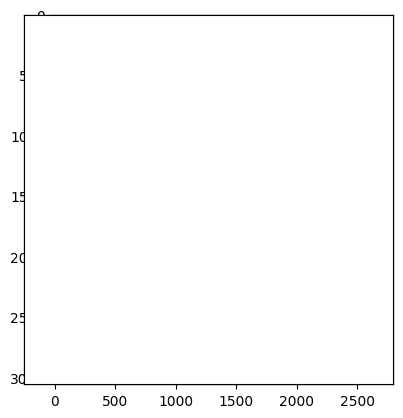

In [29]:
patientas = ['patient_17112432','patient_17172702','patient_17265926','patient_17258978','patient_17261345','patient_17267132','patient_17600369','patient_17611292',
             'patient_17741319','patient_17770657','patient_17799242','patient_17804936','patient_17970010','patient_18111516','patient_18441078','patient_18522520',
             'patient_18862368','patient_19346228','patient_19458616','patient_19486351','patient_19601036','patient_19625397','patient_19827413','patient_19918077',
             'patient_14018526','patient_14057989','patient_14094298','patient_14311521','patient_14755867','patient_14785071','patient_14850453','patient_14858737',
             'patient_14883411','patient_15047777','patient_15084163','patient_15223112','patient_15276846','patient_15880873','patient_16116913','patient_16129000',
             'patient_16164648','patient_16193784','patient_16326093','patient_16508811','patient_16570377','patient_16742247','patient_10679138','patient_10726497',
             'patient_10792610','patient_10934681','patient_11209633','patient_11411448','patient_11474034','patient_11537996','patient_11527061','patient_11566800',
             'patient_11677801','patient_11738518','patient_11752817','patient_11969967','patient_12019744','patient_12182106','patient_12169013','patient_12208824',
             'patient_12482083','patient_12528429','patient_12500924','patient_12595991','patient_12638488','patient_13017215','patient_13042648','patient_13094477',
             'patient_13128687','patient_13174810','patient_13263843','patient_13281743','patient_13516771','patient_13606683','patient_13716770','patient_13761048',
             'patient_13764208','patient_13736002','patient_13855491','patient_10103748','patient_10141577','patient_10141364','patient_10255285','patient_10439781',
             'patient_10481689','patient_10481158','patient_10543994','patient_10610928']


for key, item in _reflacx_speech.items():
    if key in ["P102R108387","P102R379837","P102R558314","P102R765317","P102R915878"]:
        continue
    print(key)
    #"""
    image = "/content/drive/MyDrive/XAMI-MIMIC/patient_12500924/CXR-JPG/s57000847/ecaab183-6c08f6b8-21edcbae-0f9547f2-c28f62d0.jpg"
    img = plt.imread(image)
    ellipses_points = []
    reflacx_points = np.array([(x,y) for x, y in zip(item['x_position'], item['y_position'])])
    trainBirchGetResults(item,reflacx_points,ellipses_points,3,3056,2544,img,'Reflacx',"exemple",'All')
    #"""
    break

#Scores and Evaluation

In [ ]:
%%script echo skipping
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/normal_graphs.pkl', 'wb') as file:
  pickle.dump(graphs_before_spar,file)

with open('/content/drive/MyDrive/REFLACX-Study/Pickle/nn.pkl', 'wb') as file:
  pickle.dump(reflacx_5_graph_nn,file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/seq.pkl', 'wb') as file:
  pickle.dump(reflacx_5_graph_seq,file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/spect.pkl', 'wb') as file:
  pickle.dump(reflacx_5_graph_spect,file)

In [ ]:
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/normal_graphs.pkl', 'rb') as file:
  graphs_before_spar = pickle.load(file)

with open('/content/drive/MyDrive/REFLACX-Study/Pickle/nn.pkl', 'rb') as file:
  nn = pickle.load(file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/seq.pkl', 'rb') as file:
  seq = pickle.load(file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/spect.pkl', 'rb') as file:
  spect = pickle.load(file)

with open('/content/drive/MyDrive/REFLACX-Study/Pickle/nn_compare.pkl', 'rb') as file:
  nn_compare = pickle.load(file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/seq_compare.pkl', 'rb') as file:
  seq_compare = pickle.load(file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/spect_compare.pkl', 'rb') as file:
  spect_compare = pickle.load(file)

In [ ]:
def compareGraphs(original, sparcified):
  #Graph before sparcification
  org_diameter = nx.diameter(original)
  org_between = nx.betweenness_centrality(original)
  org_avg_between = sum(org_between.values()) / len(org_between)
  adj_org = nx.adjacency_matrix(original)

  #Graph after sparcification
  is_connected = nx.is_connected(sparcified)
  if is_connected:
    spar_diameter = nx.diameter(sparcified)
  else:
    components = nx.connected_components(sparcified)
    # Calculate the diameter for each component
    diameters = []
    for component in components:
        subgraph = sparcified.subgraph(component)
        diameter = nx.diameter(subgraph)
        diameters.append(diameter)
    # Calculate the average diameter
    spar_diameter = sum(diameters) / len(diameters)


  spar_between = nx.betweenness_centrality(sparcified)
  spar_avg_between = sum(spar_between.values()) / len(spar_between)
  adj_spar = nx.adjacency_matrix(sparcified)

  mse = (adj_org - adj_spar) ** 2

  return spar_diameter/org_diameter, spar_avg_between/org_avg_between, mse


In [ ]:
nn_d_score = []
nn_b_score = []
nn_m_score = []
seq_d_score = []
seq_b_score = []
seq_m_score = []
spect_d_score = []
spect_b_score = []
spect_m_score = []

for i in graphs_before_spar.keys():
  d,b,m = compareGraphs(graphs_before_spar[i], nn[i])
  nn_d_score.append(d)
  nn_b_score.append(b)
  nn_m_score.append(m)

  di,bi,mi = compareGraphs(graphs_before_spar[i], seq[i])
  seq_d_score.append(di)
  seq_b_score.append(bi)
  seq_m_score.append(mi)

  dj,bj,mj = compareGraphs(graphs_before_spar[i], spect[i])
  spect_d_score.append(dj)
  spect_b_score.append(bj)
  spect_m_score.append(mj)


# Diameter
# maximum length of the shortest path between any pair of vertices in the graph (longest distance between any two vertices in the graph)
# provides an understanding of how "spread out" the graph is and can be useful in analyzing its connectivity
# can assess how the sparsification affects the overall connectivity and distance between vertices
# If the diameter increases significantly, suggests that the graph becomes more disconnected or that the remaining connections are longer

# Betweenness
# measure that quantifies the importance or centrality of a vertex within a graph
# Vertices with high betweenness centrality tend to lie on many shortest paths and can play a crucial role in connecting different parts of the graph
# compare how the removal of edges affects the centrality of individual vertices
# If betweenness decreases the sparsification process may have disrupted their role in connecting different parts of the graph

In [ ]:
def Avg(lst):
    return sum(lst) / len(lst)


print('NN Scores')
print(Avg(nn_d_score))
print(Avg(nn_b_score))
#print(Avg(nn_m_score))
print('Sequential Scores')
print(Avg(seq_d_score))
print(Avg(seq_b_score))
#print(Avg(seq_m_score))
print('Spectral Scores')
print(Avg(spect_d_score))
print(Avg(spect_b_score))
#print(Avg(spect_m_score))

NN Scores
1.402824122148495
1.7892405955395312
Sequential Scores
6.6625623936136895
6.607716292528087
Spectral Scores
0.962226703157526
1.0541073125985831


In [ ]:
graphs_with_zero = [7,10,11,12,13,14,21,24,32,33,46,48,55,56,58,59,60,71,73,74,90,91,92,93,94,95,99,115,117,118,119,130,131,132,134,139,142,150,151,152,153,157,163,165,166,167,168,181,182,183,184,191,192,193,194,195,196,197,198,199,204,205,206,207,208,209,218,226,235,236,237,238,239,250,251,252,253,254,255,256,257,258,259,261,265,268,269,270,271,272,273,274,280,281,282,283,296,297,298,307,310,311,312,313,317,325,326,327,328,329,330,331,332,333,334,343,356,363,377,380,381,382,383,384,397,399,405,406,407,408,409,411,412,413,441,444,445,446,447,448,449]

# there exist some reports that claim the patient had no abnormalities while others claim otherwise
patients_with_zero = ['patient_10481158','patient_10481689','patient_10726497','patient_11209633','patient_11411448','patient_11474034','patient_11527061','patient_11537996','patient_11677801','patient_11969967','patient_12169013','patient_12182106','patient_12208824','patient_12500924','patient_12528429','patient_12638488','patient_13094477','patient_13128687','patient_13281743','patient_13516771','patient_13736002','patient_13761048','patient_13855491','patient_14094298','patient_14311521','patient_14755867','patient_14850453','patient_14858737','patient_14883411','patient_15047777','patient_15276846','patient_16116913','patient_16129000','patient_16164648','patient_16193784','patient_16508811','patient_16742247','patient_17172702','patient_17261345','patient_17265926','patient_17600369','patient_17770657','patient_17804936','patient_17970010','patient_18441078','patient_19458616','patient_19486351','patient_19918077']

filtered_zeros = [value for value in graphs_with_zero if value in nn]



In [ ]:
nn_zero = {key: nn[key] for key in filtered_zeros}
seq_zero = {key: seq[key] for key in filtered_zeros}
spect_zero = {key: spect[key] for key in filtered_zeros}

nn_grakel = {}
seq_grakel = {}
spect_grakel = {}

for key, value in nn_zero.items():
  nn_grakel[key] = graph_from_networkx([value])

for key, value in seq_zero.items():
  seq_grakel[key] = graph_from_networkx([value])

for key, value in spect_zero.items():
  spect_grakel[key] = graph_from_networkx([value])


In [ ]:
from grakel.utils import graph_from_networkx

def GKM(graph1, graph2):
  # Convert the graphs to GraKel format
  graph1_grakel = graph_from_networkx([graph1])
  graph2_grakel = graph_from_networkx([graph2])

  # Initialize and compute the Graphlet Kernel
  gk = GraphKernel(kernel={"name": "graphlet_sampling"})
  kernel_matrix = gk.fit_transform(graph1_grakel, graph2_grakel)
  # similarity matrix representing the pairwise similarity between the graphs
  # higher score means graphs are more similar to each other
  return kernel_matrix


nn_compare_zero = {key1: {key2: GKM(value2,value1) for key2, value2 in nn_zero.items() if key2 != key1}
            for key1, value1 in spect.items()}
seq_compare_zero = {key1: {key2: GKM(value2,value1) for key2, value2 in seq_zero.items() if key2 != key1}
            for key1, value1 in spect.items()}
spect_compare_zero = {key1: {key2: GKM(value2,value1) for key2, value2 in spect_zero.items() if key2 != key1}
            for key1, value1 in spect.items()}



KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/nn_compare_zeros.pkl', 'wb') as file:
  pickle.dump(nn_compare_zero,file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/seq_compare_zeros.pkl', 'wb') as file:
  pickle.dump(seq_compare_zero,file)
with open('/content/drive/MyDrive/REFLACX-Study/Pickle/spect_compare_zeros.pkl', 'wb') as file:
  pickle.dump(spect_compare_zero,file)

In [ ]:
print(dict(sorted(nn_compare[0].items(), key=lambda item: item[1],reverse=True)))

{8: array([[221653.]]), 18: array([[178318.]]), 42: array([[176800.]]), 62: array([[174070.]]), 39: array([[173073.]]), 21: array([[161583.]]), 22: array([[161039.]]), 23: array([[158441.]]), 52: array([[151024.]]), 20: array([[143882.]]), 15: array([[140584.]]), 40: array([[134365.]]), 6: array([[130367.]]), 65: array([[119937.]]), 48: array([[115105.]]), 7: array([[114231.]]), 57: array([[112700.]]), 47: array([[103956.]]), 55: array([[88393.]]), 53: array([[81756.]]), 25: array([[81627.]]), 61: array([[79881.]]), 14: array([[79799.]]), 51: array([[79621.]]), 12: array([[77844.]]), 56: array([[76993.]]), 58: array([[71849.]]), 10: array([[66898.]]), 46: array([[65957.]]), 24: array([[65562.]]), 17: array([[65205.]]), 9: array([[64891.]]), 63: array([[61731.]]), 16: array([[61145.]]), 49: array([[59846.]]), 45: array([[59790.]]), 27: array([[59671.]]), 32: array([[53588.]]), 41: array([[53079.]]), 64: array([[52938.]]), 11: array([[52207.]]), 50: array([[52012.]]), 28: array([[50248.]